# Training Set Size Analysis

This notebook analyzes how the number of unique participants in the training set impacts the model's performance.

The goal is to understand:
- How model performance scales with training set size (number of unique participants)
- Whether there are diminishing returns as we add more participants
- What is the minimum viable training set size for acceptable performance

## Plan:
1. Load the training dataset and examine participant distribution
2. Create function to sample subset of participants from the training set
3. Train models on subsets of varying sizes (10%, 20%, ..., 100% of unique participants)
4. Evaluate each model's performance on the fixed test set
5. Log training runs in Weights & Biases
6. Generate performance plots and histograms

## Setup

In [1]:
!pip install osfclient --quiet
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet
!pip install wandb --quiet
!pip install --upgrade keras --quiet
!pip install keras-hub --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.5 MB/s eta 0:00:00


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import math
import keras
import keras_hub
from keras import ops

import wandb
from wandb.integration.keras import WandbMetricsLogger

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.custom_layers import (
    SimpleTimeDistributed,
    MaskedWeightedRidgeRegressionLayer,
    MaskInspectorLayer,
)
from et_util.model_analysis import plot_model_performance

import random
from collections import defaultdict

In [4]:
# Set environment variables for API access
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
os.environ['OSF_TOKEN'] = userdata.get('osftoken')
os.environ['OSF_USERNAME'] = userdata.get('osfusername')

In [5]:
keras.version()

'3.10.0'

In [6]:
keras.mixed_precision.set_global_policy('float32')

In [7]:
# Fixed constants - matching the analysis notebook
MAX_TARGETS = 288  # 144 per phase

# Config constants - using same as original model for consistency
EMBEDDING_DIM = 200
RIDGE_REGULARIZATION = 0.1
MIN_CAL_POINTS = 8
MAX_CAL_POINTS = 40

BACKBONE = "densenet"

# Reduced training parameters for faster experimentation
INITIAL_LEARNING_RATE = 0.00001
LEARNING_RATE = 0.01
BATCH_SIZE = 5
TRAIN_EPOCHS = 20  # Reduced from 50 for faster iteration
WARMUP_EPOCHS = 1  # Reduced from 2
DECAY_EPOCHS = TRAIN_EPOCHS - WARMUP_EPOCHS
DECAY_ALPHA = 0.01

# Augmentation disabled for consistent comparison
AUGMENTATION = False

# Analysis-specific parameters
PARTICIPANT_PERCENTAGES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
RANDOM_SEED = 42

print(f"Will train {len(PARTICIPANT_PERCENTAGES)} models with different participant subset sizes")
print(f"Participant percentages: {PARTICIPANT_PERCENTAGES}")

Will train 10 models with different participant subset sizes
Participant percentages: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [8]:
# Download training dataset from OSF (original training project)
if not os.path.exists('training_single_eye_tfrecords.tar.gz'):
    !osf -p 6b5cd fetch single_eye_tfrecords.tar.gz training_single_eye_tfrecords.tar.gz

100% 2.50G/2.50G [02:29<00:00, 16.7Mbytes/s]


In [9]:
# Download test dataset from the correct OSF project (used in analysis notebook)
if not os.path.exists('single_eye_tfrecords.tar.gz'):
    !osf -p uf2sh fetch single_eye_tfrecords.tar.gz

100% 675M/675M [00:42<00:00, 16.0Mbytes/s]


In [10]:
# Extract training dataset
if not os.path.exists('training_single_eye_tfrecords'):
    !mkdir training_single_eye_tfrecords
    !tar -xf training_single_eye_tfrecords.tar.gz -C training_single_eye_tfrecords

# Extract test dataset
if not os.path.exists('single_eye_tfrecords'):
    !mkdir single_eye_tfrecords
    !tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [11]:
def parse_training(element):
    """Process function for training data (no phase information)."""
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    landmarks = content['landmarks']
    raw_image = content['eye_img']
    label = [content['x'], content['y']]
    subject_id = content['subject_id']

    landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    landmarks = tf.reshape(landmarks, shape=(478, 3))
    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, landmarks, label, subject_id

def parse_test(element):
    """Process function for test data (includes phase information)."""
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'phase': tf.io.FixedLenFeature([], tf.int64),  # Phase information for test data
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    raw_image = content['eye_img']
    phase = content['phase']
    coords = [content['x'], content['y']]
    subject_id = content['subject_id']

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, phase, coords, subject_id

In [12]:
# Load the training dataset (for training different models)
train_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'training_single_eye_tfrecords/',
    parse_training,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, landmarks, coords, subject_id: subject_id
)

In [13]:
# Load the test dataset (this will be used for evaluation)
test_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse_test,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, phase, coords, subject_id: subject_id
)

In [14]:
def rescale_coords_map(eyes, mesh, coords, id):
    return eyes, mesh, tf.divide(coords, tf.constant([100.])), id

train_data_rescaled = train_data.map(rescale_coords_map)
test_data_rescaled = test_data.map(rescale_coords_map)

## Analyze Participant Distribution

In [15]:
# Collect all unique participant IDs from the training dataset
participant_ids = set()
participant_counts = defaultdict(int)

print("Analyzing participant distribution in training data...")
for i, (image, landmarks, coords, subject_id) in enumerate(train_data_rescaled):
    if i % 10000 == 0:
        print(f"Processed {i} samples...")

    subject_id_np = subject_id.numpy()
    participant_ids.add(subject_id_np)
    participant_counts[subject_id_np] += 1

participant_ids = sorted(list(participant_ids))
total_participants = len(participant_ids)
total_samples = sum(participant_counts.values())

print(f"Training dataset statistics:")
print(f"Total unique participants: {total_participants}")
print(f"Total samples: {total_samples}")
print(f"Average samples per participant: {total_samples / total_participants:.1f}")
print(f"Min samples per participant: {min(participant_counts.values())}")
print(f"Max samples per participant: {max(participant_counts.values())}")

Analyzing participant distribution in training data...
Processed 0 samples...
Processed 10000 samples...
Processed 20000 samples...
Processed 30000 samples...
Processed 40000 samples...
Processed 50000 samples...
Processed 60000 samples...
Processed 70000 samples...
Processed 80000 samples...
Processed 90000 samples...
Processed 100000 samples...
Processed 110000 samples...
Processed 120000 samples...
Processed 130000 samples...
Processed 140000 samples...
Processed 150000 samples...
Processed 160000 samples...
Processed 170000 samples...
Processed 180000 samples...
Processed 190000 samples...
Processed 200000 samples...
Processed 210000 samples...
Processed 220000 samples...
Processed 230000 samples...
Processed 240000 samples...
Training dataset statistics:
Total unique participants: 1726
Total samples: 244779
Average samples per participant: 141.8
Min samples per participant: 1
Max samples per participant: 144


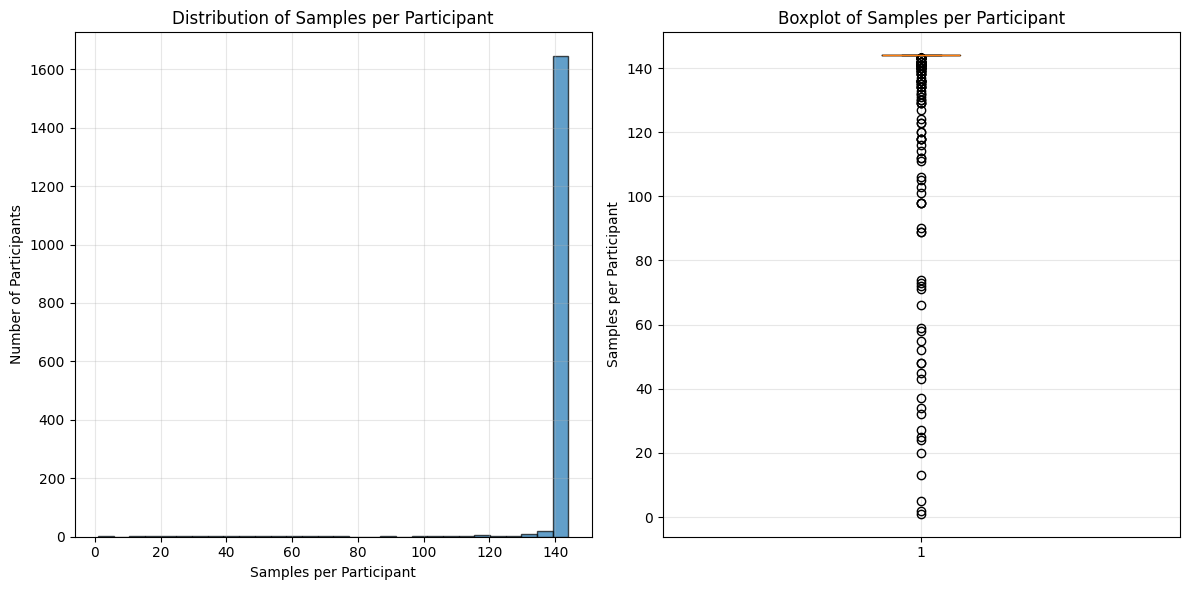

Median samples per participant: 144.0
Standard deviation: 13.1


In [16]:
# Plot distribution of samples per participant
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
samples_per_participant = list(participant_counts.values())
plt.hist(samples_per_participant, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Samples per Participant')
plt.ylabel('Number of Participants')
plt.title('Distribution of Samples per Participant')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(samples_per_participant)
plt.ylabel('Samples per Participant')
plt.title('Boxplot of Samples per Participant')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Median samples per participant: {np.median(samples_per_participant):.1f}")
print(f"Standard deviation: {np.std(samples_per_participant):.1f}")

## Helper Functions

In [17]:
def sample_participants(participant_ids, percentage, random_seed=None):
    """Sample a percentage of participants from the full list.

    Args:
        participant_ids: List of all participant IDs
        percentage: Float between 0 and 1 indicating what percentage to sample
        random_seed: Optional random seed for reproducibility

    Returns:
        List of sampled participant IDs
    """
    if random_seed is not None:
        random.seed(random_seed)

    n_participants = int(len(participant_ids) * percentage)
    sampled_ids = random.sample(participant_ids, n_participants)

    print(f"Sampled {len(sampled_ids)} participants ({percentage*100:.1f}%) from {len(participant_ids)} total")
    return sampled_ids


def filter_dataset_by_participants(dataset, participant_ids_to_keep):
    """Filter dataset to only include data from specified participants.

    Args:
        dataset: TensorFlow dataset
        participant_ids_to_keep: Set of participant IDs to keep

    Returns:
        Filtered TensorFlow dataset
    """
    participant_ids_set = set(participant_ids_to_keep)

    def filter_func(image, landmarks, coords, subject_id):
        return tf.py_function(
            lambda sid: sid.numpy() in participant_ids_set,
            [subject_id],
            tf.bool
        )

    return dataset.filter(filter_func)

In [18]:
# Copy the dataset preparation functions from the original notebook
def prepare_masked_dataset(dataset, calibration_points=None):
    # Step 1: Group dataset by subject_id and batch all images
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, mesh, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    # Step 2: Filter out subjects with fewer than 144 images
    def filter_by_image_count(images, meshes, coords, subject_ids):
        return tf.shape(images)[0] >= 144

    grouped_dataset = grouped_dataset.filter(filter_by_image_count)

    # Step 3: Transform each batch to include masks
    def add_masks_to_batch(images, meshes, coords, subject_ids):
        actual_batch_size = tf.shape(images)[0]

        cal_mask = tf.zeros(MAX_TARGETS, dtype=tf.int8)
        target_mask = tf.zeros(MAX_TARGETS, dtype=tf.int8)

        # Determine how many calibration images to use
        if calibration_points is None:
            n_cal_images = tf.random.uniform(
                shape=[],
                minval=MIN_CAL_POINTS,
                maxval=MAX_CAL_POINTS,
                dtype=tf.int32
            )
            random_indices = tf.random.shuffle(tf.range(actual_batch_size))
            cal_indices = random_indices[:n_cal_images]

            cal_mask = tf.scatter_nd(
                tf.expand_dims(cal_indices, 1),
                tf.ones(n_cal_images, dtype=tf.int8),
                [MAX_TARGETS]
            )
        else:
            coords_xpand = tf.expand_dims(coords, axis=1)
            cal_xpand = tf.expand_dims(calibration_points, axis=0)
            equality = tf.equal(coords_xpand, cal_xpand)
            matches = tf.reduce_all(equality, axis=-1)
            point_matches = tf.reduce_any(matches, axis=1)
            cal_mask = tf.cast(point_matches, dtype=tf.int8)

        target_mask = 1 - cal_mask

        # Pad everything to fixed size
        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(
            coords,
            [[0, MAX_TARGETS - actual_batch_size], [0, 0]]
        )

        # Ensure all shapes are fixed
        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(target_mask, [MAX_TARGETS])

        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids

    # Apply the transformation
    masked_dataset = grouped_dataset.map(
        lambda imgs, meshes, coords, subj_ids: add_masks_to_batch(imgs, meshes, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset


def prepare_model_inputs(features, labels, subject_ids):
    """Restructure the inputs for the model, using the mask-based approach."""
    images, coords, cal_mask, target_mask = features

    inputs = {
        "Input_All_Images": images,
        "Input_All_Coords": coords,
        "Input_Calibration_Mask": cal_mask,
    }

    return inputs, labels, target_mask

In [22]:
def prepare_masked_test_dataset(dataset, calibration_points=None, cal_phase=1):
    """
    Prepare test dataset with phase-based calibration and target separation.
    Uses phase 1 for calibration and phase 2 for targets by default.
    """
    # Step 1: Group dataset by subject_id and batch all images
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    # Step 2: Filter out subjects with insufficient data
    def filter_by_image_count(images, phase, coords, subject_ids):
        total_image_count = tf.shape(images)[0] >= MAX_TARGETS
        phase1_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 1), tf.int32)) >= 144
        phase2_image_count = tf.reduce_sum(tf.cast(tf.equal(phase, 2), tf.int32)) >= 144
        return tf.logical_and(total_image_count, tf.logical_and(phase1_image_count, phase2_image_count))

    grouped_dataset = grouped_dataset.filter(filter_by_image_count)

    # Step 3: Transform each batch to include masks
    def add_masks_to_batch(images, phase, coords, subject_ids):
        actual_batch_size = tf.shape(images)[0]

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        cal_mask = tf.zeros(actual_batch_size, dtype=tf.int8)

        if calibration_points is None:
            raise ValueError("Need to specify calibration points for test evaluation")
        else:
            coords_xpand = tf.expand_dims(coords, axis=1)
            cal_xpand = tf.expand_dims(calibration_points, axis=0)
            equality = tf.equal(coords_xpand, cal_xpand)
            matches = tf.reduce_all(equality, axis=-1)
            point_matches = tf.reduce_any(matches, axis=1)
            cal_mask = tf.cast(point_matches, dtype=tf.int8)

        # Target mask: ALL phase 2 points
        target_mask = phase2_mask

        # Apply phase restriction to calibration mask
        if cal_phase == 1:
            cal_mask = cal_mask * phase1_mask
        elif cal_phase == 2:
            cal_mask = cal_mask * phase2_mask

        # Pad to fixed size
        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(coords, [[0, MAX_TARGETS - actual_batch_size], [0, 0]])
        padded_cal_mask = tf.pad(cal_mask, [[0, MAX_TARGETS - actual_batch_size]])
        padded_target_mask = tf.pad(target_mask, [[0, MAX_TARGETS - actual_batch_size]])

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])

        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset


def prepare_model_inputs_test(features, labels, subject_ids):
    """Restructure the inputs for the model, using the mask-based approach for test data."""
    images, coords, cal_mask, target_mask = features

    inputs = {
        "Input_All_Images": images,
        "Input_All_Coords": coords,
        "Input_Calibration_Mask": cal_mask,
    }

    return inputs, labels, target_mask

In [23]:
# Define fixed calibration points for test evaluation
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

print(f"Using {len(scaled_cal_points)} fixed calibration points for test evaluation")

# Prepare test dataset with phase-based calibration points (matching analysis notebook)
test_masked_dataset = prepare_masked_test_dataset(
    test_data_rescaled,
    calibration_points=scaled_cal_points,
    cal_phase=1  # Use phase 1 for calibration
)

test_ds = test_masked_dataset.map(
    prepare_model_inputs_test,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print("Test dataset prepared with phase-based calibration")

Using 20 fixed calibration points for test evaluation
Test dataset prepared with phase-based calibration


## Training Loop for Different Participant Subset Sizes

In [24]:
def create_masked_model_training():
    """Create a model that uses masks to distinguish calibration and target images for training."""
    input_all_images = keras.layers.Input(
        shape=(144, 36, 144, 1),  # Training uses 144 targets
        name="Input_All_Images"
    )
    input_all_coords = keras.layers.Input(
        shape=(144, 2),
        name="Input_All_Coords"
    )
    input_cal_mask = keras.layers.Input(
        shape=(144,),
        name="Input_Calibration_Mask",
    )

    embedding_model = create_embedding_model(BACKBONE)
    all_embeddings = SimpleTimeDistributed(embedding_model, name="Image_Embeddings")(input_all_images)

    calibration_weights = keras.layers.Dense(
        1,
        activation="sigmoid",
        name="Calibration_Weights"
    )(all_embeddings)

    ridge = MaskedWeightedRidgeRegressionLayer(
        RIDGE_REGULARIZATION,
        name="Regression"
    )([
        all_embeddings,
        input_all_coords,
        calibration_weights,
        input_cal_mask,
    ])

    full_model = keras.Model(
        inputs=[
            input_all_images,
            input_all_coords,
            input_cal_mask,
        ],
        outputs=ridge,
        name="MaskedEyePredictionModel"
    )

    return full_model


def create_masked_model_test():
    """Create a model that uses masks to distinguish calibration and target images for testing."""
    input_all_images = keras.layers.Input(
        shape=(MAX_TARGETS, 36, 144, 1),  # Test uses 288 targets
        name="Input_All_Images"
    )
    input_all_coords = keras.layers.Input(
        shape=(MAX_TARGETS, 2),
        name="Input_All_Coords"
    )
    input_cal_mask = keras.layers.Input(
        shape=(MAX_TARGETS,),
        name="Input_Calibration_Mask",
    )

    embedding_model = create_embedding_model(BACKBONE)
    all_embeddings = SimpleTimeDistributed(embedding_model, name="Image_Embeddings")(input_all_images)

    calibration_weights = keras.layers.Dense(
        1,
        activation="sigmoid",
        name="Calibration_Weights"
    )(all_embeddings)

    ridge = MaskedWeightedRidgeRegressionLayer(
        RIDGE_REGULARIZATION,
        name="Regression"
    )([
        all_embeddings,
        input_all_coords,
        calibration_weights,
        input_cal_mask,
    ])

    full_model = keras.Model(
        inputs=[
            input_all_images,
            input_all_coords,
            input_cal_mask,
        ],
        outputs=ridge,
        name="MaskedEyePredictionModel"
    )

    return full_model

In [ ]:
# Initialize Weights & Biases for the full experiment
wandb.login()

# Dictionary to store results for each experiment
experiment_results = {}

print(f"Starting training experiments with {len(PARTICIPANT_PERCENTAGES)} different subset sizes...")

for i, percentage in enumerate(PARTICIPANT_PERCENTAGES):
    print(f"\\n{'='*60}")
    print(f"Experiment {i+1}/{len(PARTICIPANT_PERCENTAGES)}: Training with {percentage*100:.0f}% of participants")
    print(f"{'='*60}")
    
    # Sample participants for this experiment
    sampled_participants = sample_participants(
        participant_ids, 
        percentage, 
        random_seed=RANDOM_SEED + i  # Different seed for each experiment
    )
    
    # Filter training dataset to only include sampled participants
    print("Filtering training dataset...")
    subset_train_data = filter_dataset_by_participants(train_data_rescaled, sampled_participants)
    
    # Prepare training dataset
    print("Preparing masked dataset...")
    subset_masked_dataset = prepare_masked_dataset_training(subset_train_data)
    subset_train_ds = subset_masked_dataset.map(
        prepare_model_inputs_training,
        num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(200).prefetch(tf.data.AUTOTUNE)
    
    # Count number of training samples for this subset
    n_training_samples = 0
    for _ in subset_train_ds.as_numpy_iterator():
        n_training_samples += 1
    
    print(f"Training samples in subset: {n_training_samples}")
    
    # Initialize W&B run for this experiment
    config = {
        "experiment_type": "training_set_size_analysis",
        "participant_percentage": percentage,
        "n_participants": len(sampled_participants),
        "n_training_samples": n_training_samples,
        "embedding_dim": EMBEDDING_DIM,
        "ridge_regularization": RIDGE_REGULARIZATION,
        "train_epochs": TRAIN_EPOCHS,
        "min_cal_points": MIN_CAL_POINTS,
        "max_cal_points": MAX_CAL_POINTS,
        "backbone": BACKBONE,
        "batch_size": BATCH_SIZE,
        "initial_learning_rate": INITIAL_LEARNING_RATE,
        "learning_rate": LEARNING_RATE,
        "augmentation": AUGMENTATION,
        "warmup_epochs": WARMUP_EPOCHS,
        "decay_epochs": DECAY_EPOCHS,
        "decay_alpha": DECAY_ALPHA,
        "random_seed": RANDOM_SEED + i,
    }
    
    run = wandb.init(
        project='eye-tracking-training-set-size-analysis',
        config=config,
        name=f"subset_{percentage*100:.0f}pct",
        reinit=True
    )
    
    # Create and compile model
    print("Creating model...")
    learning_rate_scheduler = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INITIAL_LEARNING_RATE,
        decay_steps=n_training_samples // BATCH_SIZE * DECAY_EPOCHS,
        alpha=DECAY_ALPHA,
        warmup_target=LEARNING_RATE,
        warmup_steps=n_training_samples // BATCH_SIZE * WARMUP_EPOCHS
    )
    
    model = create_masked_model_training()  # Use training model
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=learning_rate_scheduler),
        loss=normalized_weighted_euc_dist,
        jit_compile=True,
    )
    
    # Train model
    print("Starting training...")
    history = model.fit(
        subset_train_ds.batch(BATCH_SIZE), 
        epochs=TRAIN_EPOCHS, 
        callbacks=[WandbMetricsLogger()],
        verbose=1
    )
    
    # Evaluate on test set
    print("Evaluating on test set...")
    
    # Create test model with same weights
    test_model = create_masked_model_test()
    test_model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=learning_rate_scheduler),
        loss=normalized_weighted_euc_dist,
        jit_compile=True,
    )
    
    # Transfer weights from training model to test model
    # Only transfer weights for layers with matching names and shapes
    for layer in model.layers:
        try:
            test_layer = test_model.get_layer(layer.name)
            if layer.get_weights():  # Only if layer has weights
                test_layer.set_weights(layer.get_weights())
        except ValueError:
            # Skip layers that don't exist in test model or have incompatible shapes
            continue
    
    predictions = test_model.predict(test_ds.batch(1), verbose=0)
    
    # Calculate losses - only for target points (phase 2)
    batch_losses = []
    for j, (inputs, labels, target_mask) in enumerate(test_ds.as_numpy_iterator()):
        # Use target mask to only evaluate phase 2 points
        mask = target_mask.numpy().astype(bool)
        if np.any(mask):  # Only if there are target points
            pred_targets = predictions[j][mask]
            true_targets = labels[mask]
            
            # Calculate loss for this subject's target points
            subject_losses = []
            for pred_coord, true_coord in zip(pred_targets, true_targets):
                loss = normalized_weighted_euc_dist(
                    np.array([[true_coord[0], true_coord[1]]], dtype=np.float32),
                    np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
                ).numpy()[0]
                subject_losses.append(loss)
            
            # Mean loss for this subject
            if subject_losses:
                batch_losses.append(np.mean(subject_losses))
    
    # Calculate final metrics
    if batch_losses:
        final_loss_mean = np.mean(batch_losses)
        final_loss_std = np.std(batch_losses)
        final_loss_median = np.median(batch_losses)
        subject_losses = batch_losses
    else:
        final_loss_mean = float('inf')
        final_loss_std = 0.0
        final_loss_median = float('inf')
        subject_losses = []
    
    print(f"Test Results - Mean Loss: {final_loss_mean:.3f}, Std: {final_loss_std:.3f}, Median: {final_loss_median:.3f}")
    
    # Log results to W&B
    table = wandb.Table(data=[[s] for s in subject_losses], columns=["Loss"])
    loss_hist = wandb.plot.histogram(table, value="Loss", title=f"Test Loss Distribution ({percentage*100:.0f}% participants)")
    
    wandb.log({
        "final_test_loss_mean": final_loss_mean,
        "final_test_loss_std": final_loss_std,
        "final_test_loss_median": final_loss_median,
        "final_test_loss_hist": loss_hist,
        "n_participants": len(sampled_participants),
        "n_training_samples": n_training_samples
    })
    
    # Store results for analysis
    experiment_results[percentage] = {
        'n_participants': len(sampled_participants),
        'n_training_samples': n_training_samples,
        'mean_loss': final_loss_mean,
        'std_loss': final_loss_std,
        'median_loss': final_loss_median,
        'subject_losses': subject_losses,
        'training_history': history.history
    }
    
    # Clean up
    wandb.finish()
    del model, test_model
    keras.backend.clear_session()
    
    print(f"Completed experiment {i+1}/{len(PARTICIPANT_PERCENTAGES)}")

print("\\nAll training experiments completed!")

## Analysis and Visualization

In [ ]:
# Extract data for plotting
percentages = sorted(experiment_results.keys())
n_participants_list = [experiment_results[p]['n_participants'] for p in percentages]
mean_losses = [experiment_results[p]['mean_loss'] for p in percentages]
std_losses = [experiment_results[p]['std_loss'] for p in percentages]
median_losses = [experiment_results[p]['median_loss'] for p in percentages]

print("Experiment Summary:")
print("Percentage | Participants | Mean Loss | Std Loss | Median Loss")
print("-" * 65)
for i, p in enumerate(percentages):
    print(f"{p*100:8.0f}%  |    {n_participants_list[i]:6d}    | {mean_losses[i]:8.3f}  | {std_losses[i]:7.3f}  | {median_losses[i]:10.3f}")

In [ ]:
# Plot 1: Performance vs Number of Participants
plt.figure(figsize=(15, 10))

# Main performance plot
plt.subplot(2, 2, 1)
plt.errorbar(n_participants_list, mean_losses, yerr=std_losses, 
             marker='o', markersize=8, linewidth=2, capsize=5, capthick=2)
plt.xlabel('Number of Participants in Training Set')
plt.ylabel('Mean Test Loss (Normalized Euclidean Distance)')
plt.title('Model Performance vs Training Set Size')
plt.grid(True, alpha=0.3)

# Performance vs percentage
plt.subplot(2, 2, 2)
plt.plot([p*100 for p in percentages], mean_losses, 'o-', linewidth=2, markersize=8)
plt.fill_between([p*100 for p in percentages], 
                 [m-s for m, s in zip(mean_losses, std_losses)],
                 [m+s for m, s in zip(mean_losses, std_losses)],
                 alpha=0.3)
plt.xlabel('Percentage of Participants Used (%)')
plt.ylabel('Mean Test Loss')
plt.title('Performance vs Percentage of Training Data')
plt.grid(True, alpha=0.3)

# Mean vs Median comparison
plt.subplot(2, 2, 3)
plt.plot(n_participants_list, mean_losses, 'o-', label='Mean Loss', linewidth=2, markersize=8)
plt.plot(n_participants_list, median_losses, 's-', label='Median Loss', linewidth=2, markersize=8)
plt.xlabel('Number of Participants')
plt.ylabel('Test Loss')
plt.title('Mean vs Median Test Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Improvement rate (marginal benefit)
plt.subplot(2, 2, 4)
if len(mean_losses) > 1:
    improvements = [mean_losses[0] - loss for loss in mean_losses]
    marginal_improvements = [improvements[i] - improvements[i-1] if i > 0 else improvements[0] 
                           for i in range(len(improvements))]
    plt.plot(n_participants_list, marginal_improvements, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Number of Participants')
    plt.ylabel('Marginal Improvement in Loss')
    plt.title('Marginal Benefit of Adding More Participants')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot 3: Learning curves comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for p in selected_percentages:
    history = experiment_results[p]['training_history']
    if 'loss' in history:
        plt.plot(history['loss'], label=f'{p*100:.0f}% participants', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot final training loss vs test loss
final_train_losses = []
for p in percentages:
    history = experiment_results[p]['training_history']
    if 'loss' in history and len(history['loss']) > 0:
        final_train_losses.append(history['loss'][-1])
    else:
        final_train_losses.append(np.nan)

plt.scatter(final_train_losses, mean_losses, s=100, alpha=0.7)
for i, p in enumerate(percentages):
    if not np.isnan(final_train_losses[i]):
        plt.annotate(f'{p*100:.0f}%',
                    (final_train_losses[i], mean_losses[i]),
                    xytext=(5, 5), textcoords='offset points')
plt.xlabel('Final Training Loss')
plt.ylabel('Test Loss')
plt.title('Training vs Test Loss')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
min_val = min(min([x for x in final_train_losses if not np.isnan(x)]), min(mean_losses))
max_val = max(max([x for x in final_train_losses if not np.isnan(x)]), max(mean_losses))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
plt.legend()

plt.tight_layout()
plt.show()

## Key Findings and Recommendations

In [ ]:
# Calculate key metrics and findings
best_performance = min(mean_losses)
best_percentage = percentages[mean_losses.index(best_performance)]
best_n_participants = n_participants_list[mean_losses.index(best_performance)]

# Find the "knee" point (point of diminishing returns)
# Calculate improvement rate
if len(mean_losses) > 1:
    improvements = [(mean_losses[0] - loss) / mean_losses[0] * 100 for loss in mean_losses]

    # Find where improvement rate starts to plateau (less than 2% improvement)
    knee_point = None
    for i in range(1, len(improvements)):
        if i > 0 and (improvements[i] - improvements[i-1]) < 2.0:  # Less than 2% additional improvement
            knee_point = i
            break

    if knee_point is None:
        knee_point = len(percentages) - 1

    knee_percentage = percentages[knee_point]
    knee_participants = n_participants_list[knee_point]
    knee_performance = mean_losses[knee_point]

print("\n" + "="*80)
print("KEY FINDINGS AND RECOMMENDATIONS")
print("="*80)

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total participants in full dataset: {total_participants}")
print(f"   • Total training samples: {total_samples}")
print(f"   • Average samples per participant: {total_samples/total_participants:.1f}")

print(f"\n🎯 PERFORMANCE RESULTS:")
print(f"   • Best performance: {best_performance:.3f} (with {best_percentage*100:.0f}% participants = {best_n_participants} people)")
print(f"   • Worst performance: {max(mean_losses):.3f} (with {percentages[mean_losses.index(max(mean_losses))]*100:.0f}% participants)")
print(f"   • Total improvement: {((max(mean_losses) - best_performance) / max(mean_losses) * 100):.1f}%")

if len(mean_losses) > 1:
    print(f"\n📈 DIMINISHING RETURNS ANALYSIS:")
    print(f"   • Knee point (diminishing returns): {knee_percentage*100:.0f}% participants = {knee_participants} people")
    print(f"   • Performance at knee point: {knee_performance:.3f}")
    print(f"   • Performance gap from knee to best: {((knee_performance - best_performance) / best_performance * 100):.1f}%")

print(f"\n💡 RECOMMENDATIONS:")
if len(mean_losses) > 1:
    if (best_performance - knee_performance) / best_performance < 0.05:  # Less than 5% improvement
        print(f"   • MINIMUM VIABLE: Use ~{knee_percentage*100:.0f}% of participants ({knee_participants} people)")
        print(f"     - Achieves {((mean_losses[0] - knee_performance) / mean_losses[0] * 100):.1f}% of total possible improvement")
        print(f"     - Cost-effective balance of performance vs data collection effort")

    print(f"   • OPTIMAL: Use {best_percentage*100:.0f}% of participants ({best_n_participants} people) for best performance")

    # Check if there's still significant improvement at the end
    if len(mean_losses) >= 2:
        final_improvement = (mean_losses[-2] - mean_losses[-1]) / mean_losses[-2] * 100
        if final_improvement > 2:  # More than 2% improvement in last step
            print(f"   • POTENTIAL: Consider collecting more data - still seeing {final_improvement:.1f}% improvement")

print(f"\n📋 DETAILED BREAKDOWN:")
for i, p in enumerate(percentages):
    improvement = (mean_losses[0] - mean_losses[i]) / mean_losses[0] * 100
    print(f"   • {p*100:3.0f}% participants ({n_participants_list[i]:4d} people): {mean_losses[i]:.3f} loss ({improvement:5.1f}% improvement)")

print("\n" + "="*80)